# Regresión Lineal: Ejemplo 2

Se examinará el dataset llamado "Clientes" que contiene datos del sitio web y de la aplicación móvil de una compañía. Se desea construir un modelo de regresión que prediga el gasto anual del cliente en los productos de la compañía.

In [ ]:
# Solo si se corre en Google Colab
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression

spark = SparkSession.builder.appName('Ejemplo2RegLineal').getOrCreate()

In [3]:
# Cargar los datos de entrenamiento
datos = spark.read.csv("Clientes.csv", inferSchema=True, header=True)

# Mostrar el esquema de los datos
datos.printSchema()

# Mostrar los 5 primeros datos
datos.show(5)

root
 |-- Email: string (nullable = true)
 |-- Direccion: string (nullable = true)
 |-- Avatar: string (nullable = true)
 |-- Promedio sesion: double (nullable = true)
 |-- Tiempo en App: double (nullable = true)
 |-- Tiempo en SitioWeb: double (nullable = true)
 |-- Tiempo de Membresia: double (nullable = true)
 |-- Gasto Anual: double (nullable = true)

+--------------------+--------------------+----------------+------------------+------------------+------------------+-------------------+------------------+
|               Email|           Direccion|          Avatar|   Promedio sesion|     Tiempo en App|Tiempo en SitioWeb|Tiempo de Membresia|       Gasto Anual|
+--------------------+--------------------+----------------+------------------+------------------+------------------+-------------------+------------------+
|mstephenson@ferna...|835 Frank TunnelW...|          Violet| 34.49726772511229| 12.65565114916675| 39.57766801952616| 4.0826206329529615| 587.9510539684005|
|   hduke@hotm

In [4]:
# Columnas
datos.columns

['Email',
 'Direccion',
 'Avatar',
 'Promedio sesion',
 'Tiempo en App',
 'Tiempo en SitioWeb',
 'Tiempo de Membresia',
 'Gasto Anual']

In [5]:
# Datos de una fila (fila 4)
fila = datos.take(5)[3]
print(fila)

# Fila como diccionario:
# fila.asDict()

Row(Email='riverarebecca@gmail.com', Direccion='1414 David ThroughwayPort Jason, OH 22070-1220', Avatar='SaddleBrown', Promedio sesion=34.30555662975554, Tiempo en App=13.717513665142507, Tiempo en SitioWeb=36.72128267790313, Tiempo de Membresia=3.120178782748092, Gasto Anual=581.8523440352177)


In [6]:
# Recuperación de datos de la fila 4
for item in fila:
    print(item)

riverarebecca@gmail.com
1414 David ThroughwayPort Jason, OH 22070-1220
SaddleBrown
34.30555662975554
13.717513665142507
36.72128267790313
3.120178782748092
581.8523440352177


## 1. Pre-procesamiento

Los datos deben estar en dos columnas: `("etiquetas","atributos")`

In [7]:
from pyspark.ml.feature import VectorAssembler

In [8]:
# Agrupar (ensamblar) los atributos necesarios bajo el nombre "atributos"
vassembler = VectorAssembler(inputCols=['Promedio sesion', 'Tiempo en App', 'Tiempo en SitioWeb', 'Tiempo de Membresia'],
                             outputCol="atributos")

# Aplicar a los datos
datos2 = vassembler.transform(datos)

# Visualizar el resultado
datos2.show(5)

+--------------------+--------------------+----------------+------------------+------------------+------------------+-------------------+------------------+--------------------+
|               Email|           Direccion|          Avatar|   Promedio sesion|     Tiempo en App|Tiempo en SitioWeb|Tiempo de Membresia|       Gasto Anual|           atributos|
+--------------------+--------------------+----------------+------------------+------------------+------------------+-------------------+------------------+--------------------+
|mstephenson@ferna...|835 Frank TunnelW...|          Violet| 34.49726772511229| 12.65565114916675| 39.57766801952616| 4.0826206329529615| 587.9510539684005|[34.4972677251122...|
|   hduke@hotmail.com|4547 Archer Commo...|       DarkGreen| 31.92627202636016|11.109460728682564|37.268958868297744|   2.66403418213262| 392.2049334443264|[31.9262720263601...|
|    pallen@yahoo.com|24645 Valerie Uni...|          Bisque|33.000914755642675|11.330278057777512|37.110597442

In [14]:
datos2.select('Gasto Anual').describe().show()

+-------+------------------+
|summary|       Gasto Anual|
+-------+------------------+
|  count|               500|
|   mean| 499.3140382585909|
| stddev|  79.3147815497068|
|    min|256.67058229005585|
|    max| 765.5184619388373|
+-------+------------------+



In [9]:
# Visualizar el resultado (solo la columna "atributos")
datos2.select("atributos").show(5, truncate=False)

+----------------------------------------------------------------------------+
|atributos                                                                   |
+----------------------------------------------------------------------------+
|[34.49726772511229,12.65565114916675,39.57766801952616,4.0826206329529615]  |
|[31.92627202636016,11.109460728682564,37.268958868297744,2.66403418213262]  |
|[33.000914755642675,11.330278057777512,37.110597442120856,4.104543202376424]|
|[34.30555662975554,13.717513665142507,36.72128267790313,3.120178782748092]  |
|[33.33067252364639,12.795188551078114,37.53665330059473,4.446308318351434]  |
+----------------------------------------------------------------------------+
only showing top 5 rows



In [10]:
# Conjunto de datos para regresión: "atributos, gasto anual"
datos_finales = datos2.select("atributos", 'Gasto Anual')

# Separación en datos de entrenamiento y prueba (70% - 30%)
train_data, test_data = datos_finales.randomSplit([0.7, 0.3])

# Resumen de datos de entrenamiento (train)
train_data.describe().show()

# Resumen de datos de prueba (test)
test_data.describe().show()

+-------+------------------+
|summary|       Gasto Anual|
+-------+------------------+
|  count|               343|
|   mean|496.68729789143487|
| stddev| 77.47637610510844|
|    min| 275.9184206503857|
|    max| 744.2218671047146|
+-------+------------------+

+-------+------------------+
|summary|       Gasto Anual|
+-------+------------------+
|  count|               157|
|   mean| 505.0527130734601|
| stddev| 83.15509370329704|
|    min|256.67058229005585|
|    max| 765.5184619388373|
+-------+------------------+



## 2. Modelo de Regresión

In [11]:
# Creación de un objeto de Regresión Lineal
reglin = LinearRegression(featuresCol="atributos", labelCol='Gasto Anual')

# Entrenamiento del modelo
modelo = reglin.fit(train_data)

In [12]:
# Coeficientes e intercepto para la regresión lineal
print("Coeficientes:", modelo.coefficients)
print("Intercepto:", modelo.intercept)

Coeficientes: [25.165606116967457,38.74016315471885,0.41061025369501963,61.13039603939079]
Intercepto: -1030.2351442576316


In [13]:
# Métricas en el conjunto de entrenamiento
print("MAE del conjunto de entrenamiento:", modelo.summary.meanAbsoluteError)
print("RMSE del conjunto de entrenamiento:", modelo.summary.rootMeanSquaredError)
print("r2 del conjunto de entrenamiento:", modelo.summary.r2)

MAE del conjunto de entrenamiento: 7.634280910369484
RMSE del conjunto de entrenamiento: 9.531386645778355
r2 del conjunto de entrenamiento: 0.9848210548692271


In [35]:
salida = modelo.summary.predictions
#salida.show()

yreal = salida.select('Gasto Anual').collect()
ypred = salida.select('prediction').collect()

yreal[len(ypred)-1]

Row(Gasto Anual=595.8038188761143)

In [37]:
yr = []
yp = []
for i in range(len(yreal)):
  yr.append(yreal[i][0])
  yp.append(ypred[i][0])

Text(0, 0.5, 'Gasto')

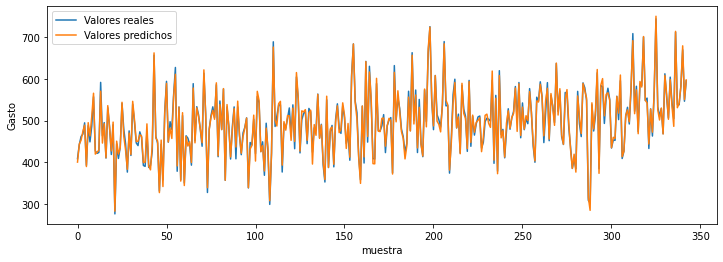

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.plot(yr)
plt.plot(yp)
plt.legend(['Valores reales', 'Valores predichos'])
plt.xlabel('muestra')
plt.ylabel('Gasto')

## 3. Evaluación del Modelo

In [49]:
# Evaluación usando el conjunto de prueba
resultados = modelo.evaluate(test_data)

# Residuos (diferencia entre valores "reales" y valores "predichos")
resultados.residuals.show(8)

+-------------------+
|          residuals|
+-------------------+
|-14.244503061789715|
|-7.9509724260311145|
|-19.774933665380217|
|-5.4739629780355585|
|  1.389899732059007|
| 2.4691099788909696|
| -18.59275459601872|
|-15.154477928046163|
+-------------------+
only showing top 8 rows



In [50]:
# Métricas de evaluación
print("MAE del conjunto de prueba:", resultados.meanAbsoluteError)
print("RMSE del conjunto de prueba:", resultados.rootMeanSquaredError)
print("MSE del conjunto de prueba:", resultados.meanSquaredError)
print("R^2 del conjunto de prueba:", resultados.r2)

MAE del conjunto de prueba: 8.504231305911073
RMSE del conjunto de prueba: 10.832836067811545
MSE del conjunto de prueba: 117.3503372720787
R^2 del conjunto de prueba: 0.9829202432321894


## 4. Predicción

In [51]:
# Generación de datos sin etiqueta (datos para los que se desea predecir)
datosp = test_data.select('atributos')
datosp.show(5)

+--------------------+
|           atributos|
+--------------------+
|[30.3931845423455...|
|[30.4925366965402...|
|[30.8162006488763...|
|[30.8794843441274...|
|[31.3091926408918...|
+--------------------+
only showing top 5 rows



In [52]:
# Predicciones sobre los datos sin etiqueta
predicciones = modelo.transform(datosp)

# Resultado
predicciones.show(8, truncate=False)

+----------------------------------------------------------------------------+------------------+
|atributos                                                                   |prediction        |
+----------------------------------------------------------------------------+------------------+
|[30.3931845423455,11.80298577760313,36.315763151803424,2.0838141920346707]  |334.1733728649833 |
|[30.4925366965402,11.562936246652605,35.97656497174036,1.4816166268553612]  |290.42221814594564|
|[30.81620064887634,11.851398743073142,36.925043038878634,1.0845853030221226]|285.8612746138492 |
|[30.879484344127498,13.280432242922114,36.93615937845674,3.5851606351613436]|495.68056296289024|
|[31.309192640891823,11.947175323941774,36.19083323650043,3.205529764506833] |431.3308181078746 |
|[31.36621216718769,11.163159542913276,37.08831936433477,3.620354588804087]  |428.11977257759395|
|[31.570200829320264,13.378063328893633,36.33780003116479,4.369366793790984] |564.5382467374236 |
|[31.574138022873235